# Predicting Index Price of DJIA w/ Financial News Sentiments

In [1]:
# Importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

from pandas_datareader.data import DataReader


In [2]:
import warnings
warnings.simplefilter("ignore")

set_seed(455)
np.random.seed(455)


### Load Data

In [7]:
# Define time period
# match with financial news data

start = datetime(2017, 12, 16)
end = datetime(2020, 7, 18)
df_prices = yf.download("^DJI", start, end)


[*********************100%%**********************]  1 of 1 completed


In [8]:
# Visualize dataframe
df_prices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-18,24739.560547,24876.070312,24739.560547,24792.199219,24792.199219,354880000
2017-12-19,24834.380859,24850.109375,24715.599609,24754.750000,24754.750000,335330000
2017-12-20,24838.089844,24852.439453,24697.109375,24726.650391,24726.650391,341790000
2017-12-21,24778.259766,24850.910156,24766.269531,24782.289062,24782.289062,339530000
2017-12-22,24764.039062,24784.150391,24717.509766,24754.060547,24754.060547,255140000


In [14]:
dates_list = df_prices.index.tolist()
dates_list[:20]

[Timestamp('2017-12-18 00:00:00'),
 Timestamp('2017-12-19 00:00:00'),
 Timestamp('2017-12-20 00:00:00'),
 Timestamp('2017-12-21 00:00:00'),
 Timestamp('2017-12-22 00:00:00'),
 Timestamp('2017-12-26 00:00:00'),
 Timestamp('2017-12-27 00:00:00'),
 Timestamp('2017-12-28 00:00:00'),
 Timestamp('2017-12-29 00:00:00'),
 Timestamp('2018-01-02 00:00:00'),
 Timestamp('2018-01-03 00:00:00'),
 Timestamp('2018-01-04 00:00:00'),
 Timestamp('2018-01-05 00:00:00'),
 Timestamp('2018-01-08 00:00:00'),
 Timestamp('2018-01-09 00:00:00'),
 Timestamp('2018-01-10 00:00:00'),
 Timestamp('2018-01-11 00:00:00'),
 Timestamp('2018-01-12 00:00:00'),
 Timestamp('2018-01-16 00:00:00'),
 Timestamp('2018-01-17 00:00:00')]

In [15]:
# Index consists of timestamp elements
timestamp = dates_list[0]

# Extracting the date as a string
date_string = timestamp.strftime('%Y-%m-%d')

2017-12-18


In [11]:
# Feed in sentiment data from csv
file_path = 'Financial_News_Sentiment.csv'
df_news = pd.read_csv(file_path, index_col=0)

In [12]:
# Visualize dataframe
df_news.head()

,Positive,Negative,Neutral
Date,,,
2020-07-18,0.135504,0.314033,0.550463
2020-07-17,0.194660,0.400375,0.404965
2020-07-16,0.198061,0.429176,0.372763
2020-07-15,0.278595,0.337260,0.384145
2020-07-14,0.231314,0.385918,0.382769


In [26]:
# Convert index values from date strings into timestamp objects
df_news.index = pd.to_datetime(df_news.index)

# Sort by index values
df_news.sort_index(ascending=True, inplace=True)

# Confirm index values for dataframes match
dates_list = df_news.index.tolist()
dates_list[:20]

[Timestamp('2017-12-17 00:00:00'),
 Timestamp('2017-12-18 00:00:00'),
 Timestamp('2017-12-19 00:00:00'),
 Timestamp('2017-12-20 00:00:00'),
 Timestamp('2017-12-21 00:00:00'),
 Timestamp('2017-12-22 00:00:00'),
 Timestamp('2017-12-25 00:00:00'),
 Timestamp('2017-12-26 00:00:00'),
 Timestamp('2017-12-27 00:00:00'),
 Timestamp('2017-12-28 00:00:00'),
 Timestamp('2017-12-30 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-02 00:00:00'),
 Timestamp('2018-01-03 00:00:00'),
 Timestamp('2018-01-04 00:00:00'),
 Timestamp('2018-01-05 00:00:00'),
 Timestamp('2018-01-06 00:00:00'),
 Timestamp('2018-01-08 00:00:00'),
 Timestamp('2018-01-09 00:00:00'),
 Timestamp('2018-01-10 00:00:00')]

In [41]:
# Merge dataframes based on prices index (timestamps)
df_merged = pd.merge(df_prices, df_news, left_index=True, right_index=True, how='left')

# Fill NaN values with 0
df_merged.fillna(0, inplace=True)

# Display the merged DataFrame
print("\nMerged DataFrame:")
df_merged.head(100)


Merged DataFrame:


,Open,High,Low,Close,Adj Close,Volume,Positive,Negative,Neutral
Date,,,,,,,,,
2017-12-18,24739.560547,24876.070312,24739.560547,24792.199219,24792.199219,354880000,0.134950,0.427190,0.437860
2017-12-19,24834.380859,24850.109375,24715.599609,24754.750000,24754.750000,335330000,0.098566,0.410148,0.491286
2017-12-20,24838.089844,24852.439453,24697.109375,24726.650391,24726.650391,341790000,0.153500,0.408590,0.437910
2017-12-21,24778.259766,24850.910156,24766.269531,24782.289062,24782.289062,339530000,0.094427,0.396806,0.508767
2017-12-22,24764.039062,24784.150391,24717.509766,24754.060547,24754.060547,255140000,0.188427,0.297866,0.513707
...,...,...,...,...,...,...,...,...,...
2018-05-07,24317.660156,24479.449219,24263.419922,24357.320312,24357.320312,307670000,0.167224,0.311097,0.521679
2018-05-08,24341.349609,24412.339844,24198.339844,24360.210938,24360.210938,344940000,0.184633,0.370310,0.445057
2018-05-09,24399.179688,24586.480469,24323.869141,24542.539062,24542.539062,361580000,0.257348,0.321024,0.421629


### Split into Train and Test

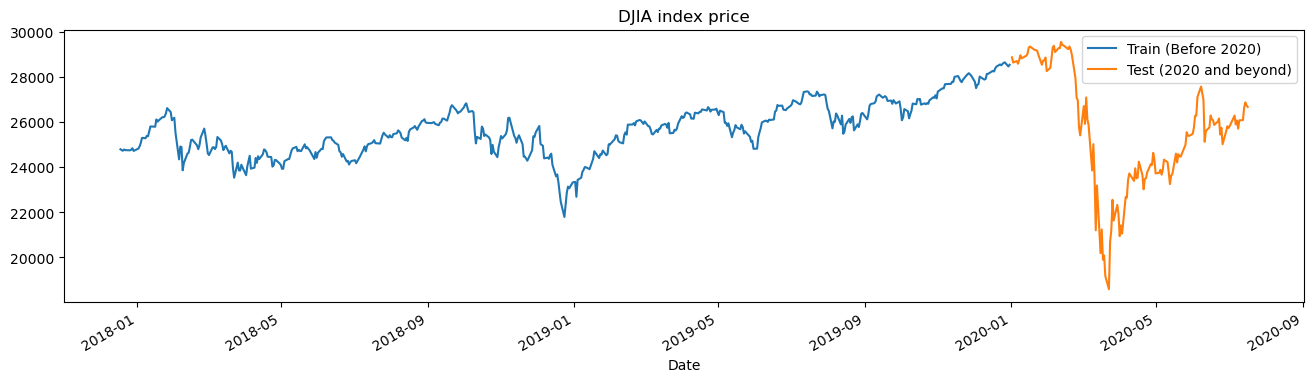

In [38]:
# split dataset for 2020 and beyond in test

tstart = 2017
tend = 2019

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "Close"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "Close"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("DJIA index price")
    plt.show()

train_test_plot(df_merged,tstart,tend)

In [106]:
# Split the prices dataframe into training and testing segments

def train_test_split(dataset, tstart, tend):
    # extract 1D arrays of closing prices from df
    p_train = dataset.loc[f"{tstart}":f"{tend}", "Close"]
    p_test = dataset.loc[f"{tend+1}":, "Close"]
    
    # extract 2D arrays of news sentiments from df
    n_train = dataset.loc[f"{tstart}":f"{tend}", ["Positive", "Neutral", "Negative"]]
    n_test = dataset.loc[f"{tend+1}":, ["Positive", "Neutral", "Negative"]]
    
    # return in array form
    return p_train.values, p_test.values, n_train.values, n_test.values

p_train, p_test, n_train, n_test = train_test_split(df_merged, tstart, tend)


In [107]:
# Scaling the prices values between (0,1) and convert to 2D column vector

sc = MinMaxScaler(feature_range=(0, 1))
p_train = p_train.reshape(-1, 1)
p_train_scaled = sc.fit_transform(p_train)

p_test = p_test.reshape(-1, 1)
p_test_scaled = sc.fit_transform(p_test)


In [126]:
print(p_train[:5])
print(p_train.shape)

[[24792.19921875]
 [24754.75      ]
 [24726.65039062]
 [24782.2890625 ]
 [24754.06054688]]
(512, 1)


In [127]:
# Reshape the news sentiment arrays into column vectors

n_train = n_train.reshape(-1, 1)
n_test = n_test.reshape(-1, 1)


In [128]:
print(n_train[:5])
print(n_train.shape)

[[0.13495041]
 [0.43785952]
 [0.42719007]
 [0.09856632]
 [0.49128579]]
(1536, 1)


In [129]:
# Split the data into vectors X (sequences of length window_size) and Y (next price target)
# Updated such that the individual sequences within X also contain the target's news sentiment scores

def split_sequence(p_sequence, n_sequence, window):
    X, y = list(), list()
    for i in range(len(p_sequence)):
        end_idx = i + window
        if end_idx > len(p_sequence) - 1:
            break # end when parsed through all window_size segments
        seq_x, seq_y = p_sequence[i:end_idx], p_sequence[end_idx]
        # incorporate sentiment
        n_idx = end_idx*3
        seq_n = n_sequence[n_idx: n_idx+3]
        seq_x = np.concatenate((seq_x, seq_n), axis=0)
        # update containers
        X.append(seq_x)
        y.append(seq_y)
    # return following iter
    return np.array(X), np.array(y)

window_size = 50 # arbitrary
features = 4 # last dimension of tensor

# Call for both training and test set

X_train, y_train = split_sequence(p_train_scaled, n_train, window_size)
X_test, y_test = split_sequence(p_test_scaled, n_test, window_size)


In [130]:
# Confirmed concatenated values within X_train

X_train[:5]


array([[[0.43776062],
        [0.43229602],
        [0.42819572],
        [0.43631452],
        [0.43219541],
        [0.43105   ],
        [0.43514887],
        [0.44437234],
        [0.42711158],
        [0.44240242],
        [0.45680035],
        [0.47904606],
        [0.51125623],
        [0.50937837],
        [0.52437908],
        [0.5219466 ],
        [0.55194774],
        [0.58528452],
        [0.58377715],
        [0.63087888],
        [0.61660207],
        [0.62446865],
        [0.64531757],
        [0.64476467],
        [0.65079243],
        [0.67131901],
        [0.70399374],
        [0.67813223],
        [0.62522305],
        [0.63580226],
        [0.64124805],
        [0.54410167],
        [0.37261465],
        [0.45535426],
        [0.4525205 ],
        [0.30180117],
        [0.35001897],
        [0.40990012],
        [0.41561722],
        [0.45254102],
        [0.49732085],
        [0.50009505],
        [0.46293926],
        [0.43857486],
        [0.46260809],
        [0

In [131]:
# Reshape X_train and X_test for 2D column vector to 3D input tensor

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)


In [149]:
# Expand feature window to include sentiment scores
feature_window = window_size + 3 

## LSTM Training and Prediction

In [132]:
# Define model architecture

model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(feature_window, features)))
model_lstm.add(Dense(25))
model_lstm.add(Dense(units=1)) # final dense layer (1) predicts value for target price

model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 25)                3150      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 66676 (260.45 KB)
Trainable params: 66676 (260.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [161]:
# Train model

model_lstm.fit(X_train, y_train, epochs=15, batch_size=32)


Epoch 1/15
15/15 [==============================] - 0s 24ms/step - loss: 0.0019
Epoch 2/15
15/15 [==============================] - 0s 23ms/step - loss: 0.0019
Epoch 3/15
15/15 [==============================] - 0s 23ms/step - loss: 0.0020
Epoch 4/15
15/15 [==============================] - 0s 23ms/step - loss: 0.0020
Epoch 5/15
15/15 [==============================] - 0s 24ms/step - loss: 0.0018
Epoch 6/15
15/15 [==============================] - 0s 25ms/step - loss: 0.0020
Epoch 7/15
15/15 [==============================] - 0s 24ms/step - loss: 0.0018
Epoch 8/15
15/15 [==============================] - 0s 24ms/step - loss: 0.0020
Epoch 9/15
15/15 [==============================] - 0s 26ms/step - loss: 0.0018
Epoch 10/15
15/15 [==============================] - 0s 24ms/step - loss: 0.0018
Epoch 11/15
15/15 [==============================] - 0s 23ms/step - loss: 0.0018
Epoch 12/15
15/15 [==============================] - 0s 23ms/step - loss: 0.0024
Epoch 13/15
15/15 [==================

In [162]:
# Make predictions on test set

predicted_index_prices = model_lstm.predict(X_test)


3/3 [==============================] - 0s 8ms/step


In [163]:
# Inverse transform both y_test and predicted_index_price

y_test_inv = sc.inverse_transform(y_test)
predicted_index_prices_inv = sc.inverse_transform(predicted_index_prices)


In [164]:
# Visualize y_test and predicted_index prices following transform

print(y_test_inv[:20], "\n\n")
print(predicted_index_prices_inv[:20])


[[20188.51953125]
 [21237.38085938]
 [19898.91992188]
 [20087.18945312]
 [19173.98046875]
 [18591.9296875 ]
 [20704.91015625]
 [21200.55078125]
 [22552.16992188]
 [21636.77929688]
 [22327.48046875]
 [21917.16015625]
 [20943.50976562]
 [21413.43945312]
 [21052.52929688]
 [22679.99023438]
 [22653.859375  ]
 [23433.5703125 ]
 [23719.36914062]
 [23390.76953125]] 


[[22358.71 ]
 [21277.906]
 [20939.191]
 [20471.455]
 [20088.574]
 [19829.889]
 [19480.7  ]
 [19951.799]
 [20500.28 ]
 [21305.74 ]
 [21644.457]
 [22195.205]
 [22232.959]
 [21882.55 ]
 [21748.143]
 [21275.855]
 [21708.244]
 [22001.98 ]
 [22523.955]
 [22841.875]]


In [168]:
# Helper functions for plotting model predictions vs true index prices

def plot_predictions(test, predicted, model_type):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title(f"Index Price Prediction for {model_type} model")
    plt.xlabel("Days following Feb 20th, 2020")
    plt.ylabel("Index Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f} USD.".format(rmse))
    

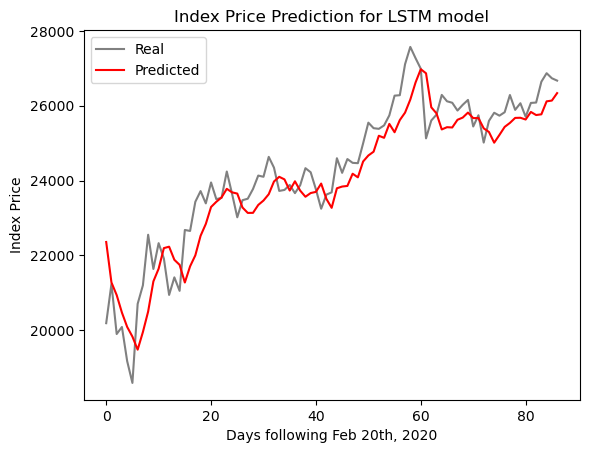

In [169]:
# Display predictions plot

plot_predictions(y_test_inv, predicted_index_prices_inv, "LSTM")


**Comments:** From the plot above, we observe that our LSTM model trained with financial news sentiment features in addition to historical index data from the last 50 days was able to decently predict low-frequency trends in DJIA index price shifts. The model outperformed its benchmark equivalent by a statistically significant margin, demonstrated by the reduction in RMSE (below) of over 100 USD.

In [167]:
# Display root mean squared error from the prediction

return_rmse(y_test_inv, predicted_index_prices_inv)


The root mean squared error is 749.06 USD.


## GRU Training and Prediction

In [153]:
# Define model architecture

model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(feature_window, features)))
model_gru.add(Dense(units=10))
model_gru.add(Dense(units=1)) # dense layer outputs target index price

model_gru.compile(optimizer="adam", loss="mse")

model_gru.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 125)               48000     
                                                                 
 dense_3 (Dense)             (None, 10)                1260      
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 49271 (192.46 KB)
Trainable params: 49271 (192.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [155]:
# Train model

model_gru.fit(X_train, y_train, epochs=15, batch_size=32)


Epoch 1/15
15/15 [==============================] - 0s 20ms/step - loss: 0.0018
Epoch 2/15
15/15 [==============================] - 0s 19ms/step - loss: 0.0019
Epoch 3/15
15/15 [==============================] - 0s 20ms/step - loss: 0.0021
Epoch 4/15
15/15 [==============================] - 0s 20ms/step - loss: 0.0021
Epoch 5/15
15/15 [==============================] - 0s 20ms/step - loss: 0.0017
Epoch 6/15
15/15 [==============================] - 0s 19ms/step - loss: 0.0017
Epoch 7/15
15/15 [==============================] - 0s 19ms/step - loss: 0.0016
Epoch 8/15
15/15 [==============================] - 0s 19ms/step - loss: 0.0018
Epoch 9/15
15/15 [==============================] - 0s 19ms/step - loss: 0.0017
Epoch 10/15
15/15 [==============================] - 0s 22ms/step - loss: 0.0016
Epoch 11/15
15/15 [==============================] - 0s 19ms/step - loss: 0.0017
Epoch 12/15
15/15 [==============================] - 0s 19ms/step - loss: 0.0019
Epoch 13/15
15/15 [==================

In [157]:
# Model predictions and inverse transform

GRU_predicted_stock_prices = model_gru.predict(X_test)
GRU_predicted_stock_prices_inv = sc.inverse_transform(GRU_predicted_stock_prices)
# y_test inverse transform stored from earlier


3/3 [==============================] - 0s 7ms/step


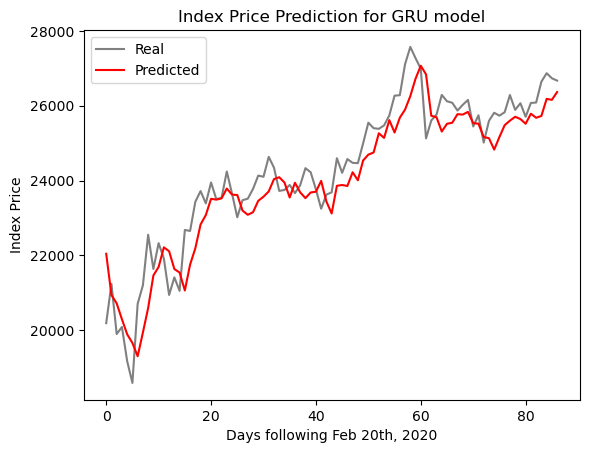

In [170]:
# Display predictions plot

plot_predictions(y_test_inv, GRU_predicted_stock_prices_inv, "GRU")


**Comments:** Based on the plot above, we can conclude that the GRU model containing financial news sentiment features captured a greater extent of high-frequency fluctions in DJIA index prices compared to that of our LSTM model before. Furthermore, this model also outperformed its benchmark equivalent as demonstrated by the reduction in RMSE value displayed below.

In [160]:
# Report root mean squared error

return_rmse(y_test_inv, GRU_predicted_stock_prices_inv)


The root mean squared error is 707.72 USD.
